Carson Dahlberg
July, 28 2018
## Capstone Proposal - Classifying Text Sentiment Polarity (positive vs. negative)
-----
* this workbook looks at the custom features
* these features were designed to try to capture some of the information lost by cleaning, preprocessing, normalizing, lemmatizing, etc...

## Import Libraries
<a id="import_id"></a>


In [1]:
# helper functions for text cleanup, preprocessing and eature engineering
import helpers as h

contractions version: contractions 0.0.16
inflect version: inflect 0.3.1


In [69]:
import re, string, unicodedata
import os, glob, sys
import logging
from time import time
import datetime

import math
import numpy as np
np.random.seed(0) # set random seed for reproducibility
import pandas as pd
pd.set_option('display.width',4000)
pd.set_option('max_colwidth',4000)
pd.set_option('max_rows',100)
pd.set_option('max_columns',200)

import scipy as sp
import sklearn

import IPython
#from IPython.core.interactiveshell import InteractiveShell
#InteractiveShell.ast_node_interactivey = "all"
from IPython.display import display
import matplotlib
import matplotlib.pyplot as plt
from matplotlib import cm

%matplotlib inline
import seaborn as sns; sns.set()

# which versions
print("Python version: {}".format(sys.version))
print("NumPy version: {}".format(np.__version__))
print("pandas version: {}".format(pd.__version__))
print("seaborn version: {}".format(sns.__version__))
print("SciPy version: {}".format(sp.__version__))
print("scikit-learn version: {}".format(sklearn.__version__))
print("IPython version: {}".format(IPython.__version__))
print("matplotlib version: {}".format(matplotlib.__version__))

Python version: 2.7.13 |Anaconda 4.3.1 (64-bit)| (default, Dec 19 2016, 13:29:36) [MSC v.1500 64 bit (AMD64)]
NumPy version: 1.11.3
pandas version: 0.19.2
seaborn version: 0.7.1
SciPy version: 0.18.1
scikit-learn version: 0.18.1
IPython version: 5.1.0
matplotlib version: 2.0.0


In [3]:
# additional smaller but useful libraries 
# contractions is capable of resolving contractions (and slang)
# could use to convert slang or create additional text
import contractions # expanding contractions here https://pypi.org/project/contractions/
print("contractions version: {}".format('contractions 0.0.16'))

# inflect.py - Correctly generate plurals, singular nouns, ordinals, indefinite articles; convert numbers to words.
# https://pypi.org/project/inflect/ 
import inflect # generating plurals, singular nouns, ordinals, indefinite articles, and converting numbers to words
print("inflect version: {}".format('inflect 0.3.1'))

contractions version: contractions 0.0.16
inflect version: inflect 0.3.1


In [4]:
import nltk
from nltk.corpus import stopwords

# custom tokenization for feature engineering using raw text
from nltk.tokenize import RegexpTokenizer

from nltk.tokenize import sent_tokenize # or can use
#from nltk.tokenize import PunktSentenceTokenizer # must be trained to be used
from nltk.tokenize import word_tokenize

from nltk.corpus import wordnet # for synonyms from WordNet

from nltk.stem import PorterStemmer # word stemming english words
from nltk.stem import SnowballStemmer # stemming non-English words
from nltk.stem import LancasterStemmer
from nltk.stem import WordNetLemmatizer # another lemmatizer

from nltk.chunk import conlltags2tree, tree2conlltags # for nltk.Tree
from nltk import pos_tag
from nltk import ne_chunk
#from nltk.tag import StanfordPOSTagger  # another POS tagger

In [5]:
# must be connected to the internet
# download and unzip the files needed
nltk.download('stopwords')
nltk.download('punkt') # for sent_tokenize
nltk.download('wordnet') # for WordNet
nltk.download('averaged_perceptron_tagger') # for NER
nltk.download('maxent_ne_chunker')
nltk.download('words')
nltk.download('nps_chat')

# call the english stopwords
len(stopwords.words('english')) # 179, but sklearn has +300

[nltk_data] Downloading package stopwords to C:\Users\Carson
[nltk_data]     Dahlberg\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package punkt to C:\Users\Carson
[nltk_data]     Dahlberg\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package wordnet to C:\Users\Carson
[nltk_data]     Dahlberg\AppData\Roaming\nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package averaged_perceptron_tagger to
[nltk_data]     C:\Users\Carson Dahlberg\AppData\Roaming\nltk_data...
[nltk_data]   Package averaged_perceptron_tagger is already up-to-
[nltk_data]       date!
[nltk_data] Downloading package maxent_ne_chunker to C:\Users\Carson
[nltk_data]     Dahlberg\AppData\Roaming\nltk_data...
[nltk_data]   Package maxent_ne_chunker is already up-to-date!
[nltk_data] Downloading package words to C:\Users\Carson
[nltk_data]     Dahlberg\AppData\Roa

179

In [6]:
# scikit-learn nlp functionality
from sklearn.model_selection import train_test_split
from sklearn.model_selection import cross_val_score, cross_val_predict
from sklearn.feature_extraction.text import ENGLISH_STOP_WORDS
print('sklearn total stop words: {}'.format(len(ENGLISH_STOP_WORDS)))

from sklearn.model_selection import GridSearchCV

from sklearn.decomposition import PCA

from sklearn.linear_model import LogisticRegression
#from sklearn.naive_bayes import MultinomialNB
from sklearn.naive_bayes import GaussianNB
from sklearn.ensemble import RandomForestClassifier
from sklearn.neighbors import KNeighborsClassifier

from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.feature_extraction.text import CountVectorizer

from sklearn.pipeline import make_pipeline

from sklearn.metrics import fbeta_score, accuracy_score

# model persistence
from sklearn.externals import joblib
# joblib.dump(clf, 'filename.pkl') 
# clf = joblib.load('filename.pkl')
# result = clf.score(X_test, y_test)
# yhat = clf.predict(X)

sklearn total stop words: 318


In [7]:
# for cleaning html and getting metadata if provided, like tags
from bs4 import BeautifulSoup

## Data - a brief description
<a id"#dat"></a>

#### Dataset for Classifying Text Sentiment Polarity (positive versus negative)
* DATA: [Sentiment Labelled Sentences Data Set](https://archive.ics.uci.edu/ml/datasets/Sentiment+Labelled+Sentences)
* SOURCE/CITATION: Dimitrios Kotzias, This dataset was created for the Paper 'From Group to Individual Labels using Deep Features', Kotzias et. al,. KDD 2015
* FORMAT: It contains sentences labelled with positive or negative sentiment. 
* DETAILS: Score is either 1 (for positive) or 0 (for negative)	The sentences come from three different websites/fields: imdb.com, amazon.com, and yelp.com. For each website, there exist 500 positive and 500 negative sentences. Those were selected randomly for larger datasets of reviews. We attempted to select sentences that have a clearly positive or negative connotaton, the goal was for no neutral sentences to be selected. 

-----
Set up where we're going to keep figures, in the project

In [8]:
# Where to save the figures
PROJECT_ROOT_DIR = "."
DATA_PATH = os.path.join(PROJECT_ROOT_DIR, "data")
IMAGES_PATH = os.path.join(PROJECT_ROOT_DIR, "images")
MODEL_PATH = os.path.join(PROJECT_ROOT_DIR, "models")
TODAY = datetime.datetime.today().strftime('%Y-%m-%d')

# make sure all paths present
if not os.path.isdir(DATA_PATH):
    os.makedirs(DATA_PATH)
if not os.path.isdir(IMAGES_PATH):
    os.makedirs(IMAGES_PATH)
if not os.path.isdir(MODEL_PATH):
    os.makedirs(MODEL_PATH)

def save_fig(fig_id, tight_layout=True, fig_extension="png", resolution=300):
    path = os.path.join(IMAGES_PATH, fig_id + "_" + TODAY + "." + fig_extension)
    print("Saving figure", fig_id)
    if tight_layout:
        plt.tight_layout()
    plt.savefig(path, format=fig_extension, dpi=resolution)

def save_model(model, model_id, model_extension="pkl"):
    path = os.path.join(MODEL_PATH, model_id + "_" + TODAY + "." + model_extension)
    print("Saving model", model_id)
    joblib.dump(model, path) 

# test saving fig
#imdb_df.len.hist(bins=100)
#save_fig('test_save_img')
#plt.show()

## Data - get raw data
-----
We're interested in a generalizable model for classifying sentiment. To do so, we are using text data collected from social media reviews, from multiple social site sources: yelp.com, imdb.com, and amazon.com. These will capture different lengths of text, differing language usage, as well as language covering many domains.

In [9]:
from glob import glob
dir_reviews = r'./data/sentiment labelled sentences/sentiment labelled sentences'
review_files = glob(dir_reviews+'/*.txt')
review_files

['./data/sentiment labelled sentences/sentiment labelled sentences\\amazon_cells_labelled.txt',
 './data/sentiment labelled sentences/sentiment labelled sentences\\imdb_labelled.txt',
 './data/sentiment labelled sentences/sentiment labelled sentences\\readme.txt',
 './data/sentiment labelled sentences/sentiment labelled sentences\\yelp_labelled.txt']

In [10]:
# pandas read_table, etc not working properly because of multiline docs.
# this will also cleanup a lot of the whitespaces, newlines, etc.
def get_sentiment_data(file_name):
    data = []
    with open(file_name, 'r') as fh:
        review = ''
        for line in fh:
            if line[-2] in ['0', '1']:
                data.append(('' + review + line[:-3], line[-2]))
                review = ''
            else:
                review += ' ' + line
    return data

# get the data
imdb_data = get_sentiment_data(review_files[1])
imdb_df = pd.DataFrame(data=imdb_data, columns=['document','score'])
imdb_df['source'] = 'imdb'
imdb_df['len'] = imdb_df['document'].str.len()

amzn_data = get_sentiment_data(review_files[0])
amzn_df = pd.DataFrame(data=amzn_data, columns=['document','score'])
amzn_df['source'] = 'amazon'
amzn_df['len'] = amzn_df['document'].str.len()

yelp_data = get_sentiment_data(review_files[3])
yelp_df = pd.DataFrame(data=yelp_data, columns=['document','score'])
yelp_df['source'] = 'yelp'
yelp_df['len'] = yelp_df['document'].str.len()

### Data Observations:
* All reviews are pulled from the sources: __Amazon__ product reviews, __Yelp__ entertainment reviews, and __IMDb__ moview reviews.
* All data is in document format with some noted similarities and differences:
    * All data has a boolean indicator of 0 or 1 for target sentiment. 
    * __Amazon__ and __Yelp__ data are the most similar, with the minimum and maximum length of Yelp both roughly twice that of Amazon. 
    * __IMDb__ data is different in one *__major__* way, each document is made of one or more sentences. This will need to be considered when incorporating the data. 
    * Interestingly __IMDb__ has both the shortest document (made up of one sentence) and longest (made up of multiple sentences).
* Casual observations about sentiment:
  * In general, positive sentiment tends to be shorter, within the same datasets.
  * In general, negative sentiment tends to be longer, within the same datasets.


In [11]:
# what do some positive reviews look like?
yelp_df['document'][yelp_df['len'] == 11]#.tolist()

165    DELICIOUS!!
479    I LOVED it!
581    Over rated.
648    Great food.
663    Both great!
Name: document, dtype: object

In [12]:
# exploring the data
lst = [('amzn', amzn_df),
        ('yelp', yelp_df),
        ('imdb', imdb_df)]
for tup in lst:
    df_neg = pd.DataFrame()
    df_pos = pd.DataFrame()
    print('*'*55)
    print('--- {} review data ---\n'.format(tup[0]))
    tup[1].info()
    display(tup[1].head())
    print('')
    print('  SENTIMENT:')
    print('    * negative doc count {}'.format(tup[1]['score'].value_counts()[0]))
    print('    * positive doc count {}\n'.format(tup[1]['score'].value_counts()[1]))

    neg_sentiment = tup[1]['score'] == '0'
    df_neg = tup[1][neg_sentiment == True].copy()
    df_pos = tup[1][neg_sentiment == False].copy()
    max_neg = df_neg['len'].max()
    min_neg = df_neg['len'].min()
    max_pos = df_pos['len'].max()
    min_pos = df_pos['len'].min()
    
    print('  LENGTH:')
    print('    negative:')
    print('      * max of {} w/ idx is/are:\n {}'.format(max_neg, df_neg['document'][df_neg['len'] == max_neg]))
    print('      * min of {} w/ idx is/are :\n {}\n'.format(min_neg, df_neg['document'][df_neg['len'] == min_neg]))
    print('    positive:')
    print('      * max of w/ idx {} is/are:\n {}'.format(max_pos, df_pos['document'][df_pos['len'] == max_pos]))
    print('      * min of w/ idx {} is/are :\n {}\n'.format(min_pos, df_pos['document'][df_pos['len'] == min_pos]))

*******************************************************
--- amzn review data ---

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1000 entries, 0 to 999
Data columns (total 4 columns):
document    1000 non-null object
score       1000 non-null object
source      1000 non-null object
len         1000 non-null int64
dtypes: int64(1), object(3)
memory usage: 31.3+ KB


,document,score,source,len
0,So there is no way for me to plug it in here in the US unless I go by a converter.,0,amazon,82
1,"Good case, Excellent value.",1,amazon,27
2,Great for the jawbone.,1,amazon,22
3,Tied to charger for conversations lasting more than 45 minutes.MAJOR PROBLEMS!!,0,amazon,79
4,The mic is great.,1,amazon,17



  SENTIMENT:
    * negative doc count 500
    * positive doc count 500

  LENGTH:
    negative:
      * max of 149 w/ idx is/are:
 65     The one big drawback of the MP3 player is that the buttons on the phone's front cover that let you pause and skip songs lock out after a few seconds.
532    Unfortunately it's easy to accidentally activate them with the gentle-touch buttons if you accidentally touch the phone to your face while listening.
Name: document, dtype: object
      * min of 11 w/ idx is/are :
 197    Bad Choice.
572    Worst ever.
Name: document, dtype: object

    positive:
      * max of w/ idx 148 is/are:
 98    Best I've found so far .... I've tried 2 other bluetooths and this one has the best quality (for both me and the listener) as well as ease of using.
Name: document, dtype: object
      * min of w/ idx 11 is/are :
 303    Good price.
666    Nice Sound.
689    Works well.
777    WORTHWHILE.
827    Good case!.
857    (It works!)
870    Works fine.
877    Excellent!.

,document,score,source,len
0,Wow... Loved this place.,1,yelp,24
1,Crust is not good.,0,yelp,18
2,Not tasty and the texture was just nasty.,0,yelp,41
3,Stopped by during the late May bank holiday off Rick Steve recommendation and loved it.,1,yelp,87
4,The selection on the menu was great and so were the prices.,1,yelp,59



  SENTIMENT:
    * negative doc count 500
    * positive doc count 500

  LENGTH:
    negative:
      * max of 149 w/ idx is/are:
 985    The problem I have is that they charge $11.99 for a sandwich that is no bigger than a Subway sub (which offers better and more amount of vegetables).
Name: document, dtype: object
      * min of 11 w/ idx is/are :
 581    Over rated.
Name: document, dtype: object

    positive:
      * max of w/ idx 148 is/are:
 549    My boyfriend and I came here for the first time on a recent trip to Vegas and could not have been more pleased with the quality of food and service.
Name: document, dtype: object
      * min of w/ idx 11 is/are :
 165    DELICIOUS!!
479    I LOVED it!
648    Great food.
663    Both great!
Name: document, dtype: object

*******************************************************
--- imdb review data ---

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1000 entries, 0 to 999
Data columns (total 4 columns):
document    1000 non-null object

,document,score,source,len
0,"A very, very, very slow-moving, aimless movie about a distressed, drifting young man.",0,imdb,87
1,"Not sure who was more lost - the flat characters or the audience, nearly half of whom walked out.",0,imdb,99
2,"Attempting artiness with black & white and clever camera angles, the movie disappointed - became even more ridiculous - as the acting was poor and the plot and lines almost non-existent.",0,imdb,188
3,Very little music or anything to speak of.,0,imdb,44
4,The best scene in the movie was when Gerardo is trying to find a song that keeps running through his head.,1,imdb,108



  SENTIMENT:
    * negative doc count 500
    * positive doc count 500

  LENGTH:
    negative:
      * max of 321 w/ idx is/are:
 428    The use of slow-motion needlessly repeats itself throughout the movie but is well backed up by bad acting (and bad is a kind word here), no continuity, scenes that are thrown in for no reason whatsoever, vehicles that looked like they were made from a Corn Flakes box and a directorial style that bordered on stupidity.  
Name: document, dtype: object
      * min of 8 w/ idx is/are :
 162    Awful.  
Name: document, dtype: object

    positive:
      * max of w/ idx 479 is/are:
 620    This is a masterful piece of film-making, with many themes simmering and occasionally boiling over in this warts and all study of the poet's bohemian, self-indulgent wartime years that span the aerial bombardments of London and the outward tranquillity of a Welsh coastal retreat - the borderlines between friendship, lust and love, dedication to art and experience versus

### Split data between training and testing
-----

#### Combine all three data sets, then check
We will create a dataframe with all of the reviews, their sentiment scores, and the length. Later we can add the predictions for later comparison between models and inspecting differences between successful/failed predictions.

In [13]:
frames = []
frames = [imdb_df, amzn_df, yelp_df]
all_reviews = pd.concat(frames, ignore_index=True, axis=0)
all_reviews['score'] = all_reviews['score'].astype(int)
all_reviews.info()
display(all_reviews.head())
print('counts for each source:')
print(all_reviews['source'].value_counts())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3000 entries, 0 to 2999
Data columns (total 4 columns):
document    3000 non-null object
score       3000 non-null int32
source      3000 non-null object
len         3000 non-null int64
dtypes: int32(1), int64(1), object(2)
memory usage: 82.1+ KB


,document,score,source,len
0,"A very, very, very slow-moving, aimless movie about a distressed, drifting young man.",0,imdb,87
1,"Not sure who was more lost - the flat characters or the audience, nearly half of whom walked out.",0,imdb,99
2,"Attempting artiness with black & white and clever camera angles, the movie disappointed - became even more ridiculous - as the acting was poor and the plot and lines almost non-existent.",0,imdb,188
3,Very little music or anything to speak of.,0,imdb,44
4,The best scene in the movie was when Gerardo is trying to find a song that keeps running through his head.,1,imdb,108


counts for each source:
yelp      1000
imdb      1000
amazon    1000
Name: source, dtype: int64


In [14]:
# save combined data 
path = os.path.join(DATA_PATH, "combined_raw_data_" + TODAY + ".csv")
all_reviews[['document','score','source']].to_csv(path, index=0)

__Split the data between train and test.__

In [15]:
# then split between train/test
# looks like the data is split relatively evenly between classes [0,1]
# checking that stratify and shuffle are, in fact, the default
X_train, X_test, y_train, y_test = train_test_split(all_reviews['document'],
                                                    all_reviews['score'],
                                                    random_state=42, 
                                                    test_size=0.2
                                                   )
print('TRAINING:')
print('  length of X_train: {}\n'.format(len(X_train)))
print("  Samples per class (training):\n{}\n".format(y_train.value_counts()))

print('TESTING:')
print('  length of : {}\n'.format(len(X_test)))
print("  Samples per class (training):\n{}\n".format(y_test.value_counts()))

TRAINING:
  length of X_train: 2400

  Samples per class (training):
0    1207
1    1193
Name: score, dtype: int64

TESTING:
  length of : 600

  Samples per class (training):
1    307
0    293
Name: score, dtype: int64



__NOTE:__ Even though the __`source`__ column has not been passed to __`train_test_split`__, the training data is stratified across __`source`__ and the __`target class`__.

In [16]:
print('Splits between target:\n----------------------')
print(X_train.to_frame().merge(all_reviews, 
                         how='inner', 
                         left_index=True, 
                         right_index=True).groupby(['source','score']).size())

Splits between target:
----------------------
source  score
amazon  0        398
        1        405
imdb    0        397
        1        386
yelp    0        412
        1        402
dtype: int64


Now that we have some intuition on how cleaning and preprocessing transforms the data, let's examine the benchmark model.

## Benchmark / Baseline - Naive Predictor Performance 
-----
*  simple baseline is just guessing the majority class (which in this case the dataset has been carefully selected to be balanced)
  * the guess should be 0.50 and the same for the f1 score (and this is what we see in the results below)
  
### Metrics
-----
**F-beta score** as a metric that considers both precision and recall:

$$ F_{\beta} = (1 + \beta^2) \cdot \frac{precision \cdot recall}{\left( \beta^2 \cdot precision \right) + recall} $$
  
  * In particular, when $\beta = 0.5$, more emphasis is placed on precision. 
  * This is called the **F$_{0.5}$ score** (or F-score for simplicity). [Precision and Recall wikipeadia](https://en.wikipedia.org/wiki/Precision_and_recall)
  

** Accuracy ** measures how often the classifier makes the correct prediction. It’s the ratio of the number of correct predictions to the total number of predictions (the number of test data points).

$$ Accuracy = \frac{tn + tp}{tp + tn + fp + fn} $$


** Precision ** tells us what proportion of messages we classified as spam, actually were spam.
It is a ratio of true positives(words classified as spam, and which are actually spam) to all positives(all words classified as spam, irrespective of whether that was the correct classificatio), in other words it is the ratio of

$$ Precision = \frac{tp}{tp + fp} $$

** Recall(sensitivity)** tells us what proportion of messages that actually were spam were classified by us as spam.
It is a ratio of true positives(words classified as spam, and which are actually spam) to all the words that were actually spam, in other words it is the ratio of

$$ Recall = \frac{tp}{tp + fn} $$

In [17]:
y = all_reviews['score']
TP = np.sum(y) # Counting the ones as this is the naive case. 
#Note that 'income' is the 'income_raw' data encoded to numerical values done in the data preprocessing step.

FP = y.count() - TP # Specific to the naive case

TN = 0 # No predicted negatives in the naive case
FN = 0 # No predicted negatives in the naive case

# Calculate accuracy, precision and recall
accuracy = float(TP + TN) / (TP + FP + TN + FN)
recall = float(TP) / (TP + FN)
precision = float(TP) / (TP + FP)
Beta = 0.5

# Calculate F-score using the formula above for beta = 0.5 and correct values for precision and recall.
fscore = (1 + Beta**2) * (precision * recall) / ((Beta**2 * precision) + recall)

# Print the results 
print("Naive Predictor: [Accuracy score: {:.4f}, F-score: {:.4f}]".format(accuracy, fscore))

Naive Predictor: [Accuracy score: 0.5000, F-score: 0.5556]


## Feature Engineering - Hand-crafted
-----
  
* Sentence level features were created and will applied using helper functions that have been coded into the __`helpers.py`__ file. 


* Sentence level features are based upon the __*raw text*__. 
  * This is an attempt to regain information that may have been lost due to the processing of normalization, standardization and cleanup. 
  * This is accomlished by using a customer parser, demonstrated below.
  * Spoiler alert, this was not very successful.

In [18]:
# There are many types of tokenizers that could be used http://www.nltk.org/api/nltk.tokenize.html#nltk.tokenize.regexp.RegexpTokenizer
# from github issues: https://stackoverflow.com/questions/36353125/nltk-regular-expression-tokenizer
text = 'That U.S.A. poster-print costs $12.40...'

pattern = r'''(?x)          # set flag to allow verbose regexps
        (?:[A-Z]\.)+        # abbreviations, e.g. U.S.A.
      | \w+(?:-\w+)*        # words with optional internal hyphens
      | \$?\d+(?:\.\d+)?%?  # currency and percentages, e.g. $12.40, 82%
      | \.\.\.              # ellipsis
      | [][.,;"'?():_`-]    # these are separate tokens; includes ], [
    '''
custome_tokenizer_test = nltk.regexp_tokenize(text=text, pattern=pattern)
print(custome_tokenizer_test)
#['That', 'U.S.A.', 'poster-print', 'costs', '$12.40', '...']

['That', 'U.S.A.', 'poster-print', 'costs', '$12.40', '...']


## Custom Sentence Level Features
-----
* From the NLTK online book, using Python to represent the following is natural and intuitive:
  * __{*w* | *w* E V & *P*(*w*)}__
  * which means, "The set of all w such that w is an element of V (vocabulary) and w has property P."
  * This can be represented in Python using a list generator:
    * __`[w for w in V if p(w)]`__
    * this is the form used to produce the sentence level features


* Sentence Level Features include:
  * __`is_capitalized`__ - True/False if the sentence starts with a capitalized letter
  * __`all_caps_sent`__ - True/False if the sentence is all caps
  * __`all_caps_word_cnt`__ - Integer number of words in the sentence which are all caps
  * __`is_all_lower`__ - True/False if the sentene is all lower case
  * __`num_chars`__ - Integer number of characters in the sentence
  * __`word_count`__ - Integer number of total words (including duplicates) in the sentence
  * __`word_to_char_frac`__ - this is average number of characters per word per sentence 
  * __`vocab_size`__ - Integer number of unique words in the sentence
  * __`diversity_score`__ - Float number fraction of total words / total unique words (aka lexical diversity)
  * __`frac_unusual`__ - Float number fraction of unusual English words which are defined here as unusual or mispelled words using Word Corpus from the /user/share/dict/words Unix file used by spellcheckers
  * __`frac_non_stop_words`__ - Float number fraction of stop words in a sentence
  
  
* These sentence level features will be used as inputs to models.


* There are more that features I wanted to add, but did not have time:
  * more sentence level features:
    * if there are elipsis in the sentence
    * if there are hyphenated words
    * if there are abbreviations
    * if money is in the sentence ex. 'All that for \$15.00\!\!\!'
  * word level features

In [19]:
# example output of the customer sentence level features
h.engineered_sentence_features(custome_tokenizer_test) 

{'all_caps_sent': False,
 'all_caps_word_cnt': 1,
 'diversity_score': 1,
 'frac_non_stop_words': 0,
 'frac_unusual': 0,
 'is_all_lower': False,
 'is_capitalized': True,
 'num_chars': 36,
 'vocab_size': 6,
 'word_count': 6,
 'word_to_char_frac': 6}

In [20]:
# view this in a transposed dataframe format
pd.DataFrame.from_dict(h.engineered_sentence_features(custome_tokenizer_test), 
                       orient='index')

,0
vocab_size,6
diversity_score,1
is_capitalized,True
word_count,6
num_chars,36
word_to_char_frac,6
frac_non_stop_words,0
all_caps_sent,False
is_all_lower,False
all_caps_word_cnt,1


## Preprocess DataFrame for ML Algos
-----
* apply custom_tokenizer
* apply engineered_sentence_features

In [21]:
# apply custom tokenizer to the dataframe with raw text
custom_tokenizer = RegexpTokenizer(pattern)

all_reviews["custom_tokens"] = all_reviews["document"].apply(custom_tokenizer.tokenize)

# review sample output
all_reviews[['document','custom_tokens']].head()

,document,custom_tokens
0,"A very, very, very slow-moving, aimless movie about a distressed, drifting young man.","[A, very, ,, very, ,, very, slow-moving, ,, aimless, movie, about, a, distressed, ,, drifting, young, man, .]"
1,"Not sure who was more lost - the flat characters or the audience, nearly half of whom walked out.","[Not, sure, who, was, more, lost, -, the, flat, characters, or, the, audience, ,, nearly, half, of, whom, walked, out, .]"
2,"Attempting artiness with black & white and clever camera angles, the movie disappointed - became even more ridiculous - as the acting was poor and the plot and lines almost non-existent.","[Attempting, artiness, with, black, white, and, clever, camera, angles, ,, the, movie, disappointed, -, became, even, more, ridiculous, -, as, the, acting, was, poor, and, the, plot, and, lines, almost, non-existent, .]"
3,Very little music or anything to speak of.,"[Very, little, music, or, anything, to, speak, of, .]"
4,The best scene in the movie was when Gerardo is trying to find a song that keeps running through his head.,"[The, best, scene, in, the, movie, was, when, Gerardo, is, trying, to, find, a, song, that, keeps, running, through, his, head, .]"


__Inspect the Custom Tokens__
  * The majority of the sentences are within the inner quartile range between 6 and 19 with the median near 12.
  * Even though there are some long documents, the majority are within a similar range.
  * Amazon and Yelp are more similar thah iMDB, which tends to have lenthier documents and appears to have more outliers.

In [22]:
all_words = [word for tokens in all_reviews["custom_tokens"] for word in tokens]
sentence_lengths = [len(tokens) for tokens in all_reviews["custom_tokens"]]
VOCAB = sorted(list(set(all_words)))
print("%s words total, with a vocabulary size of %s" % (len(all_words), len(VOCAB)))
print("Max sentence length is %s" % max(sentence_lengths))

41659 words total, with a vocabulary size of 6022
Max sentence length is 81


('Saving figure', 'sentence_length_distribution')


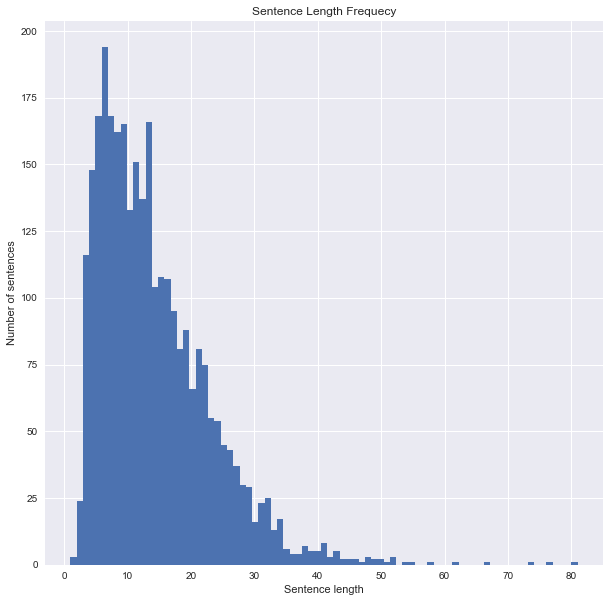

In [23]:
# this is a general view of sentence length, 
# including positive and negative sentement
fig = plt.figure(figsize=(10, 10)) 
plt.xlabel('Sentence length')
plt.ylabel('Number of sentences')
plt.title('Sentence Length Frequecy')
plt.hist(sentence_lengths,bins=81)
save_fig("sentence_length_distribution",tight_layout=False)
plt.show()

('Saving figure', 'sentence_length_boxplot')


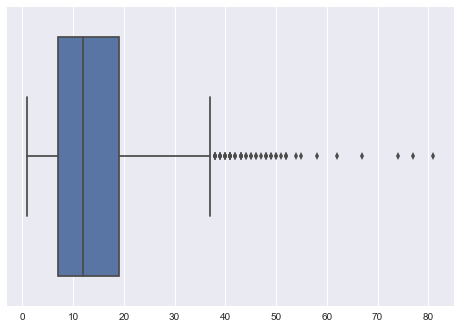

In [24]:
# sentence length by word count
# boxplot showing the median near 12, and the upper and lower quartiles
sns.boxplot(sentence_lengths)
save_fig("sentence_length_boxplot",tight_layout=False)

('Saving figure', 'sentence_length_boxplots_per_source')


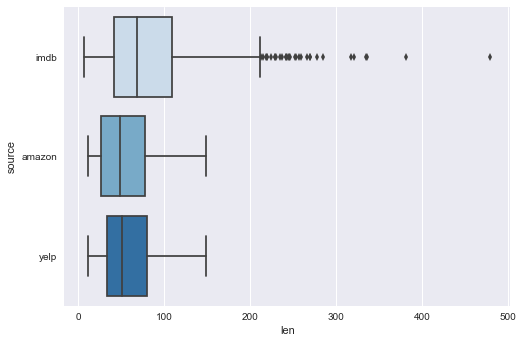

In [25]:
# breakdown of the sentence lengths by character count by source
sns.boxplot(y=all_reviews['source'], x=all_reviews['len'], palette='Blues')
save_fig("sentence_length_boxplots_per_source",tight_layout=False)

In [26]:
# since the apply functions are slow, use the data saved from previous run
if DATA_PATH:
    df_engineered_sentence_features = pd.read_csv(os.path.join(DATA_PATH, r'engineered_sentence_features.csv'), 
                                                  index_col=0)
    
else:
    # WARNING - this part is slow
    # apply custom features to the data
    all_reviews['engineered_sentence_features'] = all_reviews['custom_tokens'].apply(h.engineered_sentence_features)
    
    # flatten the engineered_sentence_features into a dataframe
    df_engineered_sentence_features = all_reviews['engineered_sentence_features'].apply(pd.Series)
    
    #save off the data to save time for reviewer
    df_engineered_sentence_features.to_csv(os.path.join(DATA_PATH, r'engineered_sentence_features.csv'))

# inspect engineered features data
display(df_engineered_sentence_features.info())
display(df_engineered_sentence_features.head())

<class 'pandas.core.frame.DataFrame'>
Int64Index: 3000 entries, 0 to 2999
Data columns (total 11 columns):
all_caps_sent          3000 non-null bool
all_caps_word_cnt      3000 non-null int64
diversity_score        3000 non-null float64
frac_non_stop_words    3000 non-null float64
frac_unusual           3000 non-null float64
is_all_lower           3000 non-null bool
is_capitalized         3000 non-null bool
num_chars              3000 non-null int64
vocab_size             3000 non-null int64
word_count             3000 non-null int64
word_to_char_frac      3000 non-null float64
dtypes: bool(3), float64(4), int64(4)
memory usage: 219.7 KB


None

,all_caps_sent,all_caps_word_cnt,diversity_score,frac_non_stop_words,frac_unusual,is_all_lower,is_capitalized,num_chars,vocab_size,word_count,word_to_char_frac
0,False,1,1.384615,0.666667,0.000000,False,True,73,12,18,4.055556
1,False,0,1.050000,0.523810,0.095238,False,True,79,20,21,3.761905
2,False,0,1.185185,0.687500,0.093750,False,True,155,27,32,4.843750
3,False,0,1.000000,0.555556,0.000000,False,True,35,9,9,3.888889
4,False,0,1.000000,0.500000,0.090909,False,True,86,21,22,3.909091


In [27]:
reviews_features = all_reviews.merge(df_engineered_sentence_features, how='outer',left_index=True, right_index=True)
reviews_features.columns.tolist()
cols_keep = ['document',
 'score',
 'source',
 'all_caps_sent',
 'all_caps_word_cnt',
 'diversity_score',
 'frac_non_stop_words',
 'frac_unusual',
 'is_all_lower',
 'is_capitalized',
 'num_chars',
 'vocab_size',
 'word_count',
 'word_to_char_frac']
display(reviews_features[cols_keep].head())
display(reviews_features[cols_keep].info())

,document,score,source,all_caps_sent,all_caps_word_cnt,diversity_score,frac_non_stop_words,frac_unusual,is_all_lower,is_capitalized,num_chars,vocab_size,word_count,word_to_char_frac
0,"A very, very, very slow-moving, aimless movie about a distressed, drifting young man.",0,imdb,False,1,1.384615,0.666667,0.000000,False,True,73,12,18,4.055556
1,"Not sure who was more lost - the flat characters or the audience, nearly half of whom walked out.",0,imdb,False,0,1.050000,0.523810,0.095238,False,True,79,20,21,3.761905
2,"Attempting artiness with black & white and clever camera angles, the movie disappointed - became even more ridiculous - as the acting was poor and the plot and lines almost non-existent.",0,imdb,False,0,1.185185,0.687500,0.093750,False,True,155,27,32,4.843750
3,Very little music or anything to speak of.,0,imdb,False,0,1.000000,0.555556,0.000000,False,True,35,9,9,3.888889
4,The best scene in the movie was when Gerardo is trying to find a song that keeps running through his head.,1,imdb,False,0,1.000000,0.500000,0.090909,False,True,86,21,22,3.909091


<class 'pandas.core.frame.DataFrame'>
Int64Index: 3000 entries, 0 to 2999
Data columns (total 14 columns):
document               3000 non-null object
score                  3000 non-null int32
source                 3000 non-null object
all_caps_sent          3000 non-null bool
all_caps_word_cnt      3000 non-null int64
diversity_score        3000 non-null float64
frac_non_stop_words    3000 non-null float64
frac_unusual           3000 non-null float64
is_all_lower           3000 non-null bool
is_capitalized         3000 non-null bool
num_chars              3000 non-null int64
vocab_size             3000 non-null int64
word_count             3000 non-null int64
word_to_char_frac      3000 non-null float64
dtypes: bool(3), float64(4), int32(1), int64(4), object(2)
memory usage: 278.3+ KB


None

In [28]:
# some quick stats on hand-engineered features

# get list of number cols
num_attribs = df_engineered_sentence_features.select_dtypes(include=[np.number]).columns.tolist()
print('num_attribs:')
display(df_engineered_sentence_features[num_attribs].describe().T)

cat_attribs = df_engineered_sentence_features.select_dtypes(include=['O','bool']).columns.tolist()
print('cat_attribs:')
display(df_engineered_sentence_features[cat_attribs].describe().T)


num_attribs:


,count,mean,std,min,25%,50%,75%,max
all_caps_word_cnt,3000.0,0.474333,0.875365,0.0,0.0,0.000000,1.000000,15.000000
diversity_score,3000.0,1.051270,0.084383,1.0,1.0,1.000000,1.090909,2.000000
frac_non_stop_words,3000.0,0.596731,0.152479,0.2,0.5,0.571429,0.666667,1.000000
frac_unusual,3000.0,0.076202,0.087251,0.0,0.0,0.062500,0.125000,0.666667
num_chars,3000.0,53.570333,36.295530,4.0,27.0,46.000000,72.000000,407.000000
vocab_size,3000.0,12.803667,7.514116,1.0,7.0,11.000000,17.000000,59.000000
word_count,3000.0,13.886333,8.960181,1.0,7.0,12.000000,19.000000,81.000000
word_to_char_frac,3000.0,3.901527,0.801059,1.8,3.4,3.833333,4.316388,11.000000


cat_attribs:


,count,unique,top,freq
all_caps_sent,3000,2,False,2994
is_all_lower,3000,2,False,2996
is_capitalized,3000,2,True,2820


# TODO
* process pipeline data prep
* split test train
* visualize distributions
* grid over default models
  * save results into dataframe
* select best model and refine
* create voting
* add vect models with feature engineered models

## reviewing samples of null vals w/ their rows
* no null values in the engineered features

In [29]:
print('missing\tcolumn name')
for col in df_engineered_sentence_features.columns:
    if df_engineered_sentence_features[col].isnull().sum() > 0:
        print('{}\t{}'.format(df_engineered_sentence_features[col].isnull().sum(), col))

missing	column name


## Categorical Engineered Features
* two are rare, one is skewed

In [33]:
# map the boolean columns to [0,1]
bool_map = {True:1, False:0}
df_engineered_sentence_features['all_caps_sent'] = df_engineered_sentence_features['all_caps_sent'].map(bool_map)
df_engineered_sentence_features['is_all_lower'] = df_engineered_sentence_features['is_all_lower'].map(bool_map)
df_engineered_sentence_features['is_capitalized'] = df_engineered_sentence_features['is_capitalized'].map(bool_map)

In [34]:
df_engineered_sentence_features.head()

,all_caps_sent,all_caps_word_cnt,diversity_score,frac_non_stop_words,frac_unusual,is_all_lower,is_capitalized,num_chars,vocab_size,word_count,word_to_char_frac
0,0,1,1.384615,0.666667,0.000000,0,1,73,12,18,4.055556
1,0,0,1.050000,0.523810,0.095238,0,1,79,20,21,3.761905
2,0,0,1.185185,0.687500,0.093750,0,1,155,27,32,4.843750
3,0,0,1.000000,0.555556,0.000000,0,1,35,9,9,3.888889
4,0,0,1.000000,0.500000,0.090909,0,1,86,21,22,3.909091


## Visualize the Numerical Engineered Features
* only one of these features looks normally distributed
* the features will need to be standardized to keep the model from favoring higher valued features

In [35]:
# Let’s plot the distribution of each feature
def plot_distribution(dataset, cols=5, width=20, height=15, hspace=0.2, wspace=0.5):
    plt.style.use('seaborn-whitegrid')
    fig = plt.figure(figsize=(width,height))
    fig.subplots_adjust(left=None, bottom=None, right=None, top=None, wspace=wspace, hspace=hspace)
    rows = math.ceil(float(dataset.shape[1]) / cols)
    for i, column in enumerate(dataset.columns):
        ax = fig.add_subplot(rows, cols, i + 1)
        ax.set_title(column)
        if dataset.dtypes[column] == np.object:
            g = sns.countplot(y=column, data=dataset)
            substrings = [s.get_text()[:18] for s in g.get_yticklabels()]
            g.set(yticklabels=substrings)
            plt.xticks(rotation=25)
        else:
            g = sns.distplot(dataset[column])
            plt.xticks(rotation=25)

('Saving figure', 'feature_engineering_original_distributions')


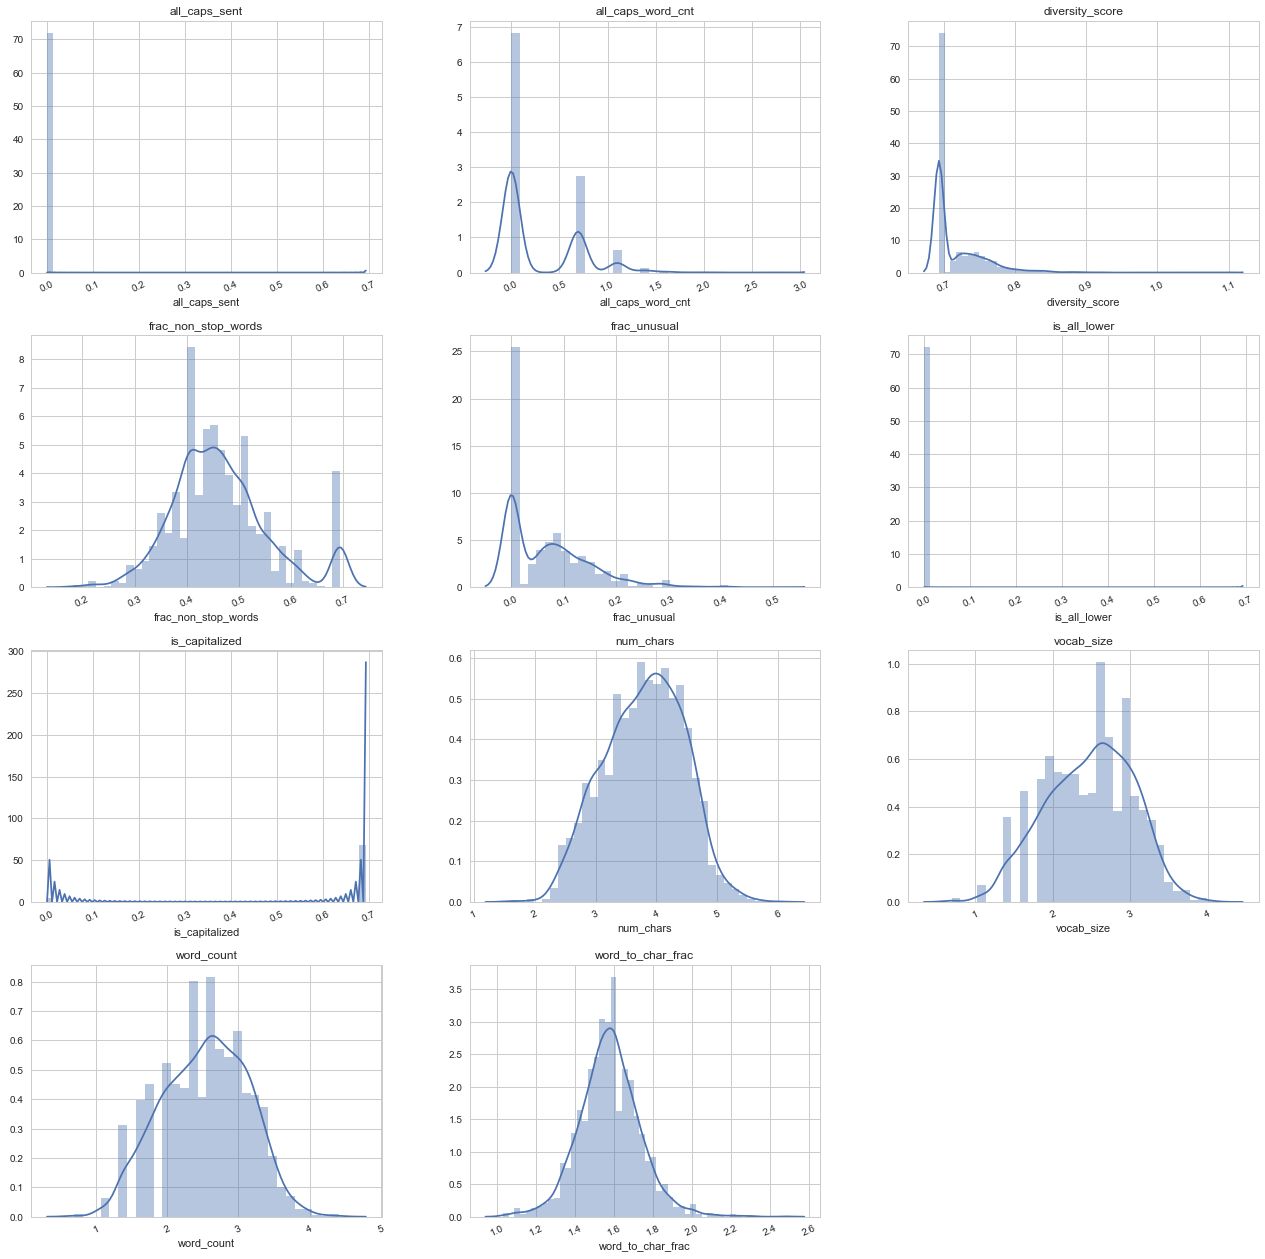

In [36]:
plot_distribution(np.log(df_engineered_sentence_features.dropna() + 1), 
                  cols=3, 
                  width=22, 
                  height=2*df_engineered_sentence_features.shape[1], 
                  hspace=0.25, 
                  wspace=0.25)

save_fig("feature_engineering_original_distributions",tight_layout=False)

## Pipeline - Preprocess the Engineered Features
-----
* create a dataframe selector 
* cleanup and create features

In [37]:
# Definition of the CategoricalEncoder class, copied from PR #9151.

from sklearn.base import BaseEstimator, TransformerMixin
from sklearn.utils import check_array
from sklearn.preprocessing import LabelEncoder
from scipy import sparse

class CategoricalEncoder(BaseEstimator, TransformerMixin):
    """Encode categorical features as a numeric array.
    The input to this transformer should be a matrix of integers or strings,
    denoting the values taken on by categorical (discrete) features.
    The features can be encoded using a one-hot aka one-of-K scheme
    (``encoding='onehot'``, the default) or converted to ordinal integers
    (``encoding='ordinal'``).
    This encoding is needed for feeding categorical data to many scikit-learn
    estimators, notably linear models and SVMs with the standard kernels.
    Read more in the :ref:`User Guide <preprocessing_categorical_features>`.
    Parameters
    ----------
    encoding : str, 'onehot', 'onehot-dense' or 'ordinal'
        The type of encoding to use (default is 'onehot'):
        - 'onehot': encode the features using a one-hot aka one-of-K scheme
          (or also called 'dummy' encoding). This creates a binary column for
          each category and returns a sparse matrix.
        - 'onehot-dense': the same as 'onehot' but returns a dense array
          instead of a sparse matrix.
        - 'ordinal': encode the features as ordinal integers. This results in
          a single column of integers (0 to n_categories - 1) per feature.
    categories : 'auto' or a list of lists/arrays of values.
        Categories (unique values) per feature:
        - 'auto' : Determine categories automatically from the training data.
        - list : ``categories[i]`` holds the categories expected in the ith
          column. The passed categories are sorted before encoding the data
          (used categories can be found in the ``categories_`` attribute).
    dtype : number type, default np.float64
        Desired dtype of output.
    handle_unknown : 'error' (default) or 'ignore'
        Whether to raise an error or ignore if a unknown categorical feature is
        present during transform (default is to raise). When this is parameter
        is set to 'ignore' and an unknown category is encountered during
        transform, the resulting one-hot encoded columns for this feature
        will be all zeros.
        Ignoring unknown categories is not supported for
        ``encoding='ordinal'``.
    Attributes
    ----------
    categories_ : list of arrays
        The categories of each feature determined during fitting. When
        categories were specified manually, this holds the sorted categories
        (in order corresponding with output of `transform`).
    Examples
    --------
    Given a dataset with three features and two samples, we let the encoder
    find the maximum value per feature and transform the data to a binary
    one-hot encoding.
    >>> from sklearn.preprocessing import CategoricalEncoder
    >>> enc = CategoricalEncoder(handle_unknown='ignore')
    >>> enc.fit([[0, 0, 3], [1, 1, 0], [0, 2, 1], [1, 0, 2]])
    ... # doctest: +ELLIPSIS
    CategoricalEncoder(categories='auto', dtype=<... 'numpy.float64'>,
              encoding='onehot', handle_unknown='ignore')
    >>> enc.transform([[0, 1, 1], [1, 0, 4]]).toarray()
    array([[ 1.,  0.,  0.,  1.,  0.,  0.,  1.,  0.,  0.],
           [ 0.,  1.,  1.,  0.,  0.,  0.,  0.,  0.,  0.]])
    See also
    --------
    sklearn.preprocessing.OneHotEncoder : performs a one-hot encoding of
      integer ordinal features. The ``OneHotEncoder assumes`` that input
      features take on values in the range ``[0, max(feature)]`` instead of
      using the unique values.
    sklearn.feature_extraction.DictVectorizer : performs a one-hot encoding of
      dictionary items (also handles string-valued features).
    sklearn.feature_extraction.FeatureHasher : performs an approximate one-hot
      encoding of dictionary items or strings.
    """

    def __init__(self, encoding='onehot', categories='auto', dtype=np.float64,
                 handle_unknown='error'):
        self.encoding = encoding
        self.categories = categories
        self.dtype = dtype
        self.handle_unknown = handle_unknown

    def fit(self, X, y=None):
        """Fit the CategoricalEncoder to X.
        Parameters
        ----------
        X : array-like, shape [n_samples, n_feature]
            The data to determine the categories of each feature.
        Returns
        -------
        self
        """

        if self.encoding not in ['onehot', 'onehot-dense', 'ordinal']:
            template = ("encoding should be either 'onehot', 'onehot-dense' "
                        "or 'ordinal', got %s")
            raise ValueError(template % self.handle_unknown)

        if self.handle_unknown not in ['error', 'ignore']:
            template = ("handle_unknown should be either 'error' or "
                        "'ignore', got %s")
            raise ValueError(template % self.handle_unknown)

        if self.encoding == 'ordinal' and self.handle_unknown == 'ignore':
            raise ValueError("handle_unknown='ignore' is not supported for"
                             " encoding='ordinal'")

        X = check_array(X, dtype=np.object, accept_sparse='csc', copy=True)
        n_samples, n_features = X.shape

        self._label_encoders_ = [LabelEncoder() for _ in range(n_features)]

        for i in range(n_features):
            le = self._label_encoders_[i]
            Xi = X[:, i]
            if self.categories == 'auto':
                le.fit(Xi)
            else:
                valid_mask = np.in1d(Xi, self.categories[i])
                if not np.all(valid_mask):
                    if self.handle_unknown == 'error':
                        diff = np.unique(Xi[~valid_mask])
                        msg = ("Found unknown categories {0} in column {1}"
                               " during fit".format(diff, i))
                        raise ValueError(msg)
                le.classes_ = np.array(np.sort(self.categories[i]))

        self.categories_ = [le.classes_ for le in self._label_encoders_]

        return self

    def transform(self, X):
        """Transform X using one-hot encoding.
        Parameters
        ----------
        X : array-like, shape [n_samples, n_features]
            The data to encode.
        Returns
        -------
        X_out : sparse matrix or a 2-d array
            Transformed input.
        """
        X = check_array(X, accept_sparse='csc', dtype=np.object, copy=True)
        n_samples, n_features = X.shape
        X_int = np.zeros_like(X, dtype=np.int)
        X_mask = np.ones_like(X, dtype=np.bool)

        for i in range(n_features):
            valid_mask = np.in1d(X[:, i], self.categories_[i])

            if not np.all(valid_mask):
                if self.handle_unknown == 'error':
                    diff = np.unique(X[~valid_mask, i])
                    msg = ("Found unknown categories {0} in column {1}"
                           " during transform".format(diff, i))
                    raise ValueError(msg)
                else:
                    # Set the problematic rows to an acceptable value and
                    # continue `The rows are marked `X_mask` and will be
                    # removed later.
                    X_mask[:, i] = valid_mask
                    X[:, i][~valid_mask] = self.categories_[i][0]
            X_int[:, i] = self._label_encoders_[i].transform(X[:, i])

        if self.encoding == 'ordinal':
            return X_int.astype(self.dtype, copy=False)

        mask = X_mask.ravel()
        n_values = [cats.shape[0] for cats in self.categories_]
        n_values = np.array([0] + n_values)
        indices = np.cumsum(n_values)

        column_indices = (X_int + indices[:-1]).ravel()[mask]
        row_indices = np.repeat(np.arange(n_samples, dtype=np.int32),
                                n_features)[mask]
        data = np.ones(n_samples * n_features)[mask]

        out = sparse.csc_matrix((data, (row_indices, column_indices)),
                                shape=(n_samples, indices[-1]),
                                dtype=self.dtype).tocsr()
        if self.encoding == 'onehot-dense':
            return out.toarray()
        else:
            return out

In [38]:
# transformer to just select a subset of the Pandas DataFrame columns:
from sklearn.base import BaseEstimator, TransformerMixin

# A class to select numerical or categorical columns 
# since Scikit-Learn doesn't handle DataFrames yet
class DataFrameSelector(BaseEstimator, TransformerMixin):
    def __init__(self, attribute_names):
        self.attribute_names = attribute_names
    def fit(self, X, y=None):
        return self
    def transform(self, X):
        return X[self.attribute_names]
    
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler, Imputer, PolynomialFeatures
from sklearn.pipeline import FeatureUnion
from sklearn.preprocessing import MaxAbsScaler, RobustScaler, MinMaxScaler


# get list of number cols
#num_attribs = df_engineered_sentence_features.select_dtypes(include=[np.number]).columns.tolist()
#cat_attribs = df_engineered_sentence_features.select_dtypes(include=['O']).columns.tolist()

# pipeline for processing numerical attribs
# fill missining w/ median
num_pipeline = Pipeline([('selector', DataFrameSelector(num_attribs)),
                        ('imputer', Imputer(missing_values='NaN', strategy='mean', axis=0)), 
                        #('robust', RobustScaler(quantile_range=(25,75))),
                        #('minmax', MinMaxScaler()),
                        ('max_abs_scaler', MaxAbsScaler())#,('polynomials', PolynomialFeatures(degree=2))
                       ])

# pipeline for processing categorical attribs
cat_pipeline = Pipeline([('selector', DataFrameSelector(cat_attribs)), 
                        ('cat_encoder', CategoricalEncoder(encoding='onehot-dense')),
                       ])

# full pre-processing pipeline
full_pipeline = FeatureUnion(transformer_list=[
        ('num_pipeline', num_pipeline),
        ('cat_pipeline', cat_pipeline),
    ])

dataset_prepped = full_pipeline.fit_transform(df_engineered_sentence_features)

#dataset_prepped = num_pipeline.fit_transform(reviews_features)

In [113]:
dataset_prepped.

<function getfield>

('Saving figure', 'feature_engineering_transformed_distributions')


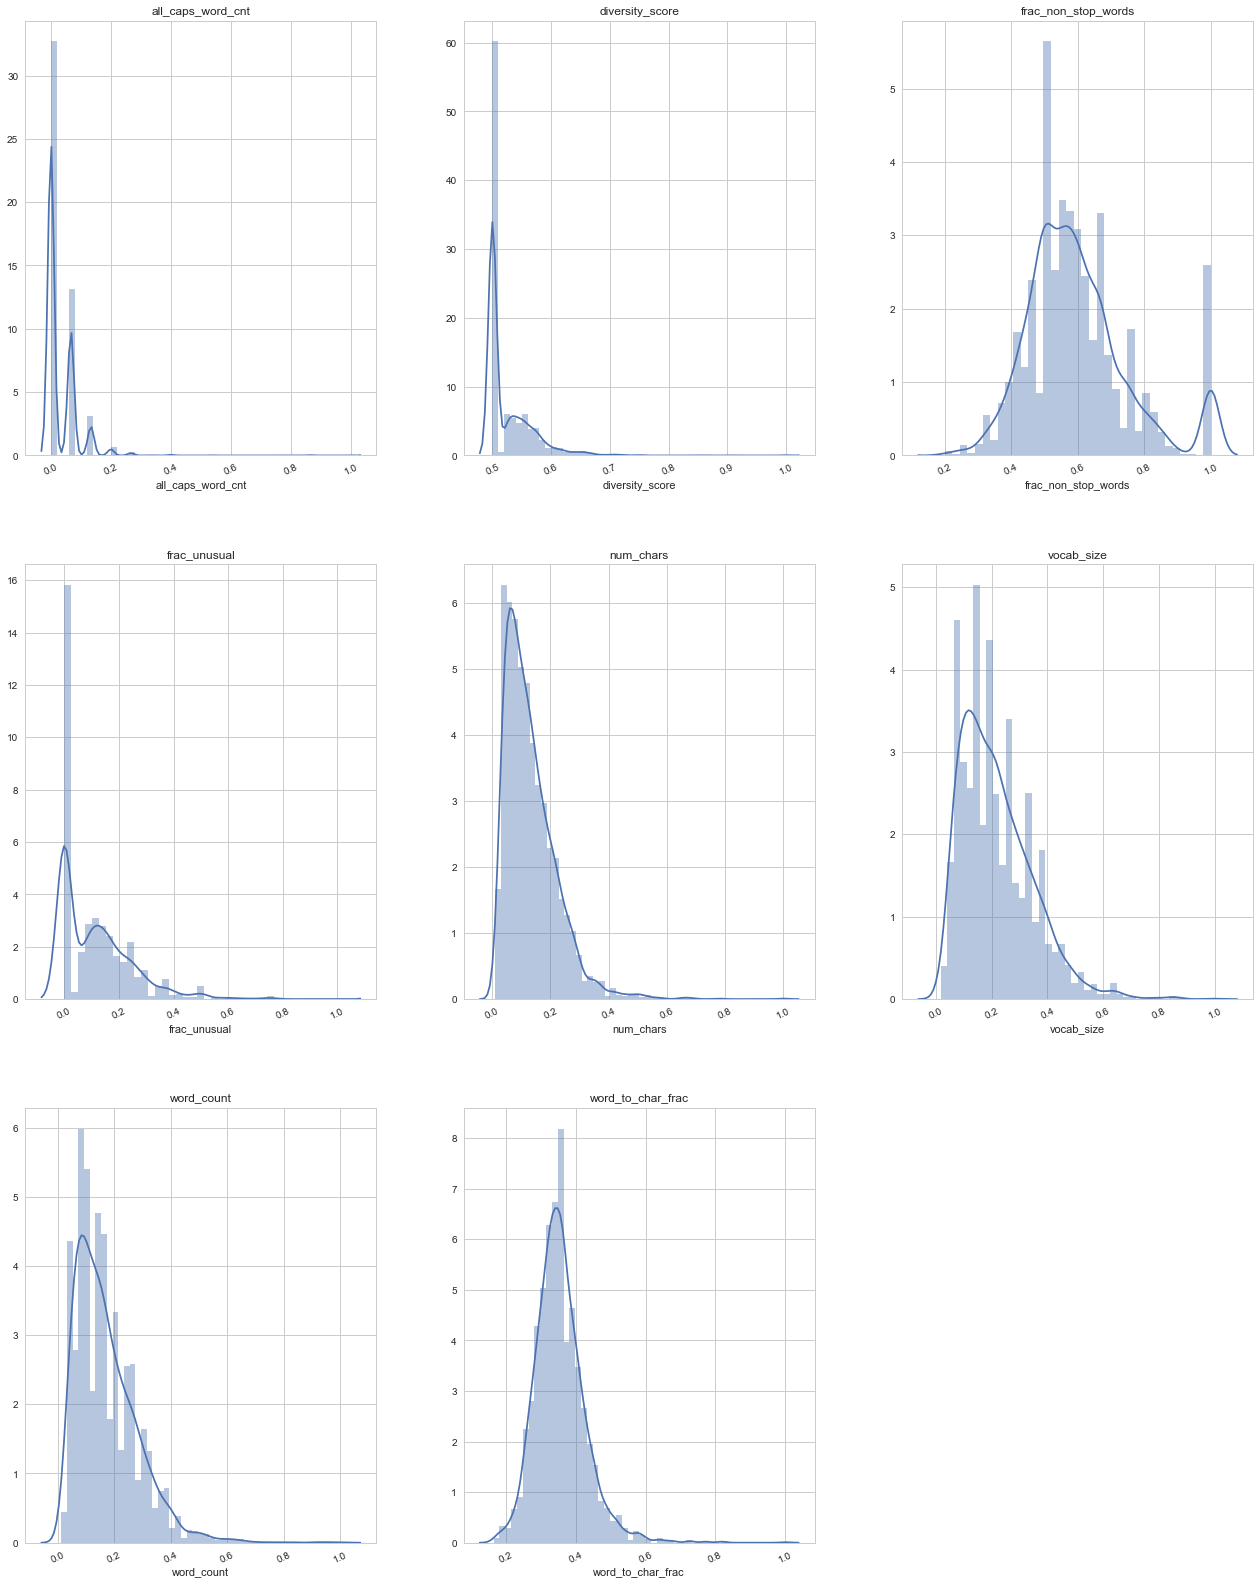

In [40]:
# only plotting the non-ploynimial, original features that are transformed
plot_distribution(pd.DataFrame(dataset_prepped[:,:len(num_attribs)], columns=num_attribs), 
                  cols=3, 
                  width=22, 
                  height=2*dataset_prepped.shape[1], 
                  hspace=0.25, 
                  wspace=0.25)

save_fig("feature_engineering_transformed_distributions",tight_layout=False)

In [41]:
# split engineered features into train and test sets
X_train, X_test, y_train, y_test = train_test_split(dataset_prepped, 
                                                    reviews_features['score'], 
                                                    test_size = 0.2, 
                                                    random_state = 42)

# Show the results of the split
print("Training set has {} samples.".format(X_train.shape[0]))
print("Testing set has {} samples.".format(X_test.shape[0]))

Training set has 2400 samples.
Testing set has 600 samples.


## Compare Various Models with the Engineered Features
-----
* utized code learned in the class
* examining more than just accuracy
  * time to train and predict
  * results with varied data sampling
  * using f1 score

In [42]:
# using setup from class to iterate through models
def train_predict(learner, sample_size, X_train, y_train, X_test, y_test): 
    '''
    inputs:
       - learner: the learning algorithm to be trained and predicted on
       - sample_size: the size of samples (number) to be drawn from training set
       - X_train: features training set
       - y_train: income training set
       - X_test: features testing set
       - y_test: income testing set
    '''
    
    results = {}
    
    # Fit the learner to the training data using slicing with 'sample_size'
    start = time() # Get start time
    learner = learner.fit(X_train[:sample_size], y_train[:sample_size])
    end = time() # Get end time
    
    # Calculate the training time
    results['train_time'] = end - start
        
    # Get the predictions on the test set(X_test),
    # then get predictions on the first 300 training samples(X_train) using .predict()
    start = time() # Get start time
    predictions_test = learner.predict(X_test)
    predictions_train = learner.predict(X_train[:300])
    end = time() # Get end time
    
    # Calculate the total prediction time
    results['pred_time'] = end - start
            
    # Compute accuracy on the first 300 training samples which is y_train[:300]
    # metrics.accuracy_score(y_true, y_pred[,...])
    results['acc_train'] = accuracy_score(y_train[:300], predictions_train)
        

    # Compute accuracy on test set using accuracy_score()
    results['acc_test'] = accuracy_score(y_test, predictions_test)
    
    # Compute F-score on the the first 300 training samples 
    # http://scikit-learn.org/0.17/modules/generated/sklearn.metrics.fbeta_score.html#sklearn.metrics.fbeta_score
    # fbeta_score(y_true, y_pred, beta, labels)
    results['f_train'] = fbeta_score(y_train[:300], predictions_train, 
                                     beta=0.5)
        
    # Compute F-score on the test set which is y_test
    results['f_test'] = fbeta_score(y_test, predictions_test, 
                                     beta=0.5)
       
    # Success
    print("{} trained on {} samples.".format(learner.__class__.__name__, sample_size))
        
    # Return the results
    return results

In [43]:
# Initialize the models
from sklearn.svm import LinearSVC
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis
from sklearn.naive_bayes import MultinomialNB

clf_A = GaussianNB()
clf_B = LinearSVC()
clf_C = LinearDiscriminantAnalysis(n_components=None, 
                                   priors=None, 
                                   shrinkage=None,
                                   solver='svd', 
                                   store_covariance=False, 
                                   tol=0.0001)

# Calculate the number of samples for 1%, 10%, and 100% of the training data
# the entire training set i.e. len(y_train)
samples_100 = len(y_train)
samples_10 = int(0.10 * samples_100)
samples_1 = int(0.01 * samples_100)

# Collect results on the learners
model_results1 = {}
for clf in [clf_A, clf_B, clf_C]:
    clf_name = clf.__class__.__name__
    model_results1[clf_name] = {}
    for i, samples in enumerate([samples_1, samples_10, samples_100]):
        model_results1[clf_name][i] = \
        train_predict(clf, samples, X_train, y_train, X_test, y_test)

GaussianNB trained on 24 samples.
GaussianNB trained on 240 samples.
GaussianNB trained on 2400 samples.
LinearSVC trained on 24 samples.
LinearSVC trained on 240 samples.
LinearSVC trained on 2400 samples.
LinearDiscriminantAnalysis trained on 24 samples.
LinearDiscriminantAnalysis trained on 240 samples.
LinearDiscriminantAnalysis trained on 2400 samples.


C:\Anaconda3\envs\python27\lib\site-packages\sklearn\discriminant_analysis.py:387: UserWarning: Variables are collinear.
  warnings.warn("Variables are collinear.")


('Saving figure', 'model_results1_engineered_features')


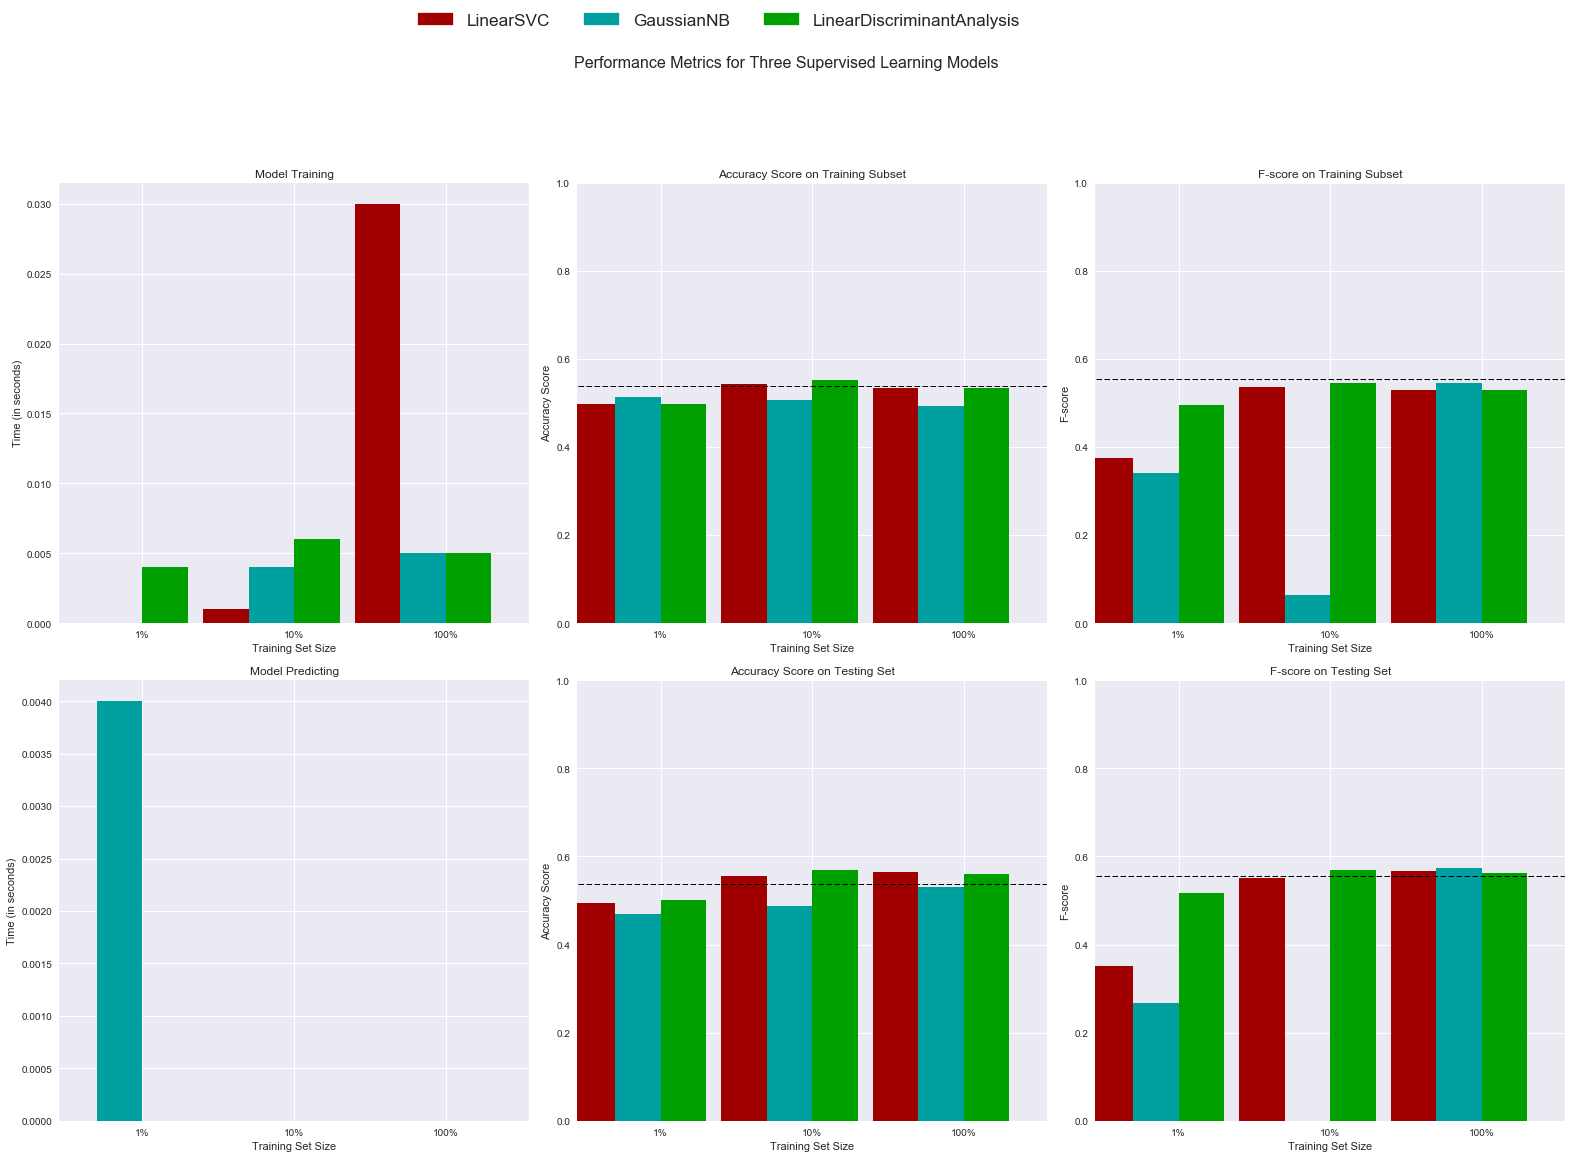

In [104]:
# review all of the numbers
#model_results1
# Run metrics visualization for the three supervised learning models chosen
h.evaluate(model_results1, accuracy, fscore)
save_fig("model_results1_engineered_features",tight_layout=False)
plt.show()

In [107]:
# Initialize the models
from sklearn.svm import LinearSVC
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis
from sklearn.naive_bayes import MultinomialNB

clf_D = KNeighborsClassifier(5)
clf_E = MultinomialNB()
clf_F = RandomForestClassifier(max_depth=3, 
                               n_estimators=100, #30, 
                               max_features=7,
                               bootstrap=True, 
                               random_state=42)

# Calculate the number of samples for 1%, 10%, and 100% of the training data
# the entire training set i.e. len(y_train)
samples_100 = len(y_train)
samples_10 = int(0.10 * samples_100)
samples_1 = int(0.01 * samples_100)

# Collect results on the learners
model_results2 = {}
for clf in [clf_D, clf_E, clf_F]:
    clf_name = clf.__class__.__name__
    model_results2[clf_name] = {}
    for i, samples in enumerate([samples_1, samples_10, samples_100]):
        model_results2[clf_name][i] = \
        train_predict(clf, samples, X_train, y_train, X_test, y_test)

KNeighborsClassifier trained on 24 samples.
KNeighborsClassifier trained on 240 samples.
KNeighborsClassifier trained on 2400 samples.
MultinomialNB trained on 24 samples.
MultinomialNB trained on 240 samples.
MultinomialNB trained on 2400 samples.
RandomForestClassifier trained on 24 samples.
RandomForestClassifier trained on 240 samples.
RandomForestClassifier trained on 2400 samples.


('Saving figure', 'model_results2_engineered_features')


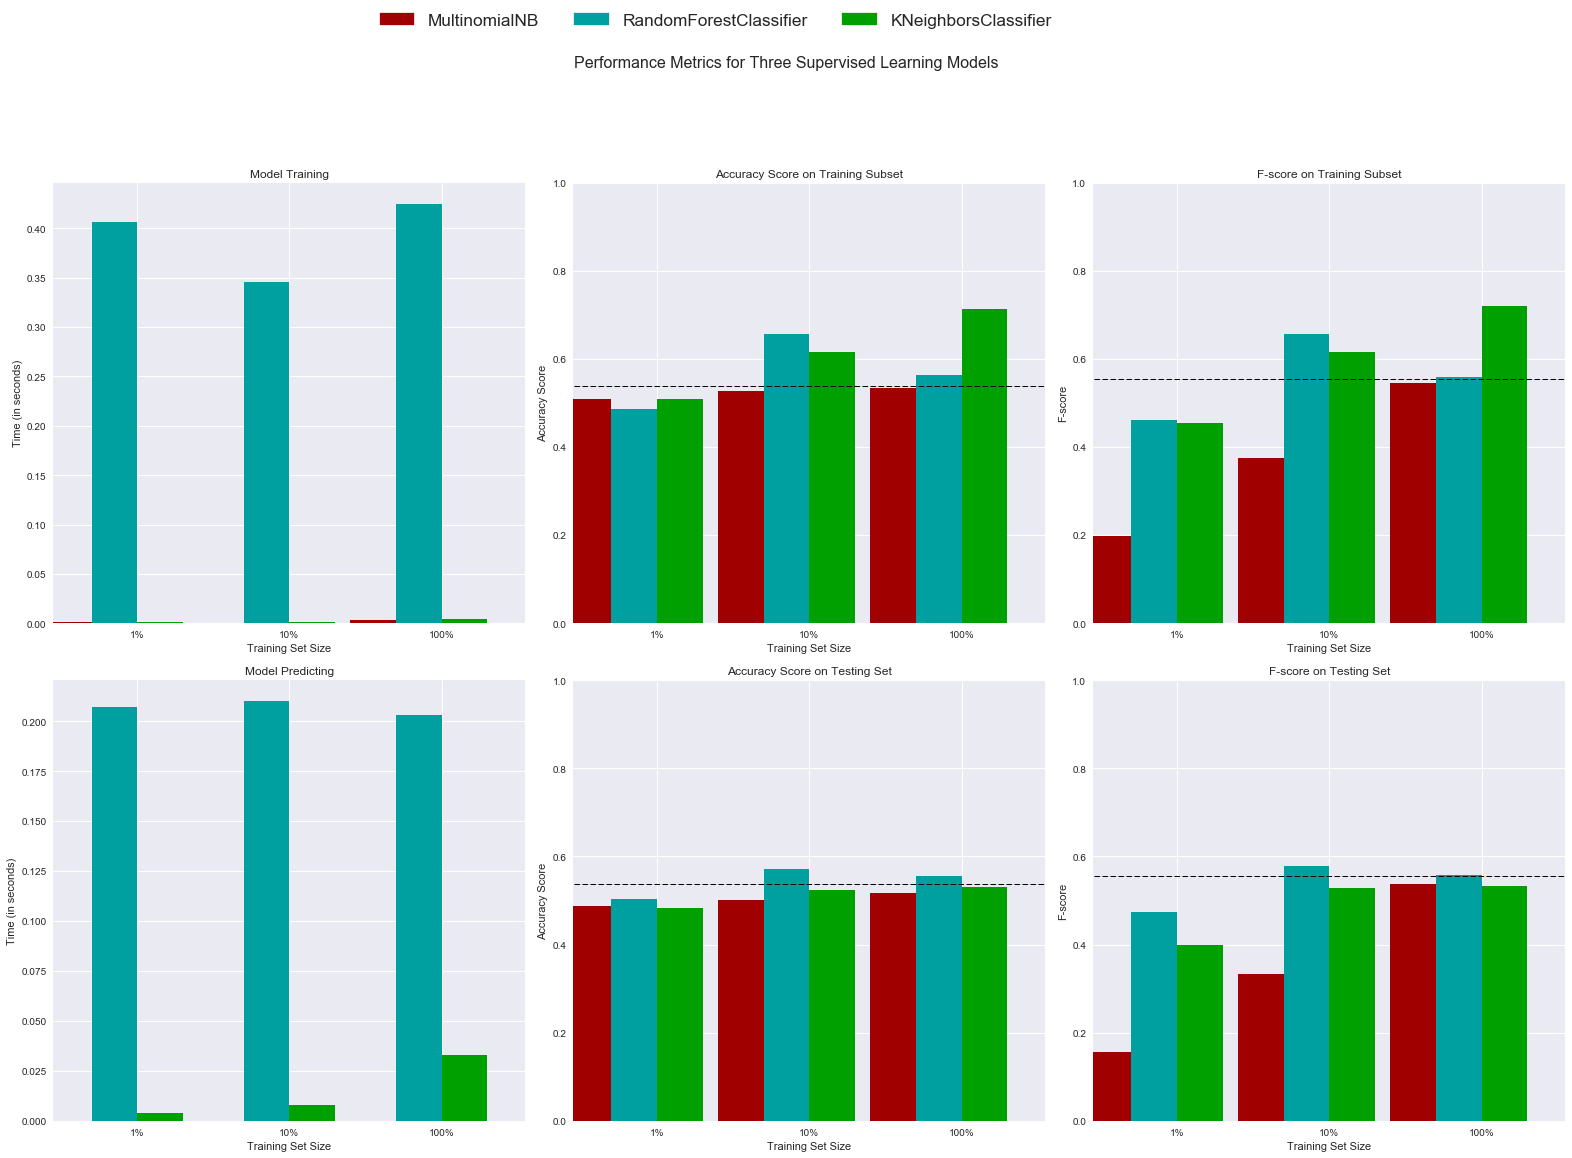

In [108]:
# review all of the numbers
#model_results2

# Run metrics visualization for the three supervised learning models chosen
h.evaluate(model_results2, accuracy, fscore)
save_fig("model_results2_engineered_features",tight_layout=False)
plt.show()

### Try Bagging (Bootstrap Aggregating) with DecisionTreeClassifier
-----
* Since RandomForrest was the best performer, try Bagging.
* get a diverse set of classifiers by training same classifier on different subsets of the training data, sampling with replacement
* predictors will be more biased but should be less correlated, reducing the ensemble's variance

In [47]:
from sklearn.ensemble import BaggingClassifier
from sklearn.tree import DecisionTreeClassifier

bag_clf = BaggingClassifier(DecisionTreeClassifier(), 
                            n_estimators=500, 
                            max_samples=100, 
                            bootstrap=True, 
                            n_jobs=3, 
                           oob_score=True)
bag_clf.fit(X_train, y_train)
bag_clf.oob_score_

0.55791666666666662

In [48]:
# predict the target from engineered features
y_pred = bag_clf.predict(X_test)

# unpack metrics using function
accuracy, precision, recall, f1 = h.get_metrics(y_test, y_pred)
print("accuracy = %.3f, precision = %.3f, recall = %.3f, f1 = %.3f" % (accuracy, precision, recall, f1))

accuracy = 0.538, precision = 0.540, recall = 0.538, f1 = 0.538


## Summary of Experiments
-----
* Unfortunately, these features alone did not provide much value, and are almost indistinguishable from the naive model of guessing the majority class. 
* The aren't really clear winners, unless you specified a particular metric:
  * *__acc_test__* - RandomForrest (slower) & LinearSVC
  * *__f_test__* -GuassianNB, LinearSVC, & RandomForrest (slower)
* For the amount of time, effort, and research invested in thinking about which features might be indicative of information which is lost when transforming the data to a more standard way of representing text (cleaned, normalized, etc.), and then the regex involved, these were dissappointing results to say the least.
* From the results, it's easy to see that models have varying strengths. Some train quickly but predict slowly, or vice versa - KNeighbors prediction time grows quickly with the size of the dataset, while other learners scale well to larger datasets. The time to process might be a real barrier to using a particular model in production.
* Many models looked promising while training, but then were dissappointing in the testing set. 

In [49]:
for model in model_results1:
    print('-------- {} tials'.format(model))
    display(pd.DataFrame.from_dict(model_results1[model], orient='columns').rename(columns={0:'1_pct',1:'10_pct',2:'100_pct'}).T)
for model in model_results2:
    print('-------- {} tials'.format(model))
    display(pd.DataFrame.from_dict(model_results2[model], orient='columns').rename(columns={0:'1_pct',1:'10_pct',2:'100_pct'}).T)

-------- LinearSVC tials


,acc_test,acc_train,f_test,f_train,pred_time,train_time
1_pct,0.493333,0.496667,0.350224,0.375648,0.0,0.000
10_pct,0.556667,0.543333,0.550459,0.537249,0.0,0.001
100_pct,0.565000,0.533333,0.566893,0.529248,0.0,0.030


-------- GaussianNB tials


,acc_test,acc_train,f_test,f_train,pred_time,train_time
1_pct,0.468333,0.513333,0.266559,0.340136,0.004,0.000
10_pct,0.486667,0.506667,0.000000,0.063291,0.000,0.004
100_pct,0.531667,0.493333,0.573903,0.546252,0.000,0.005


-------- LinearDiscriminantAnalysis tials


,acc_test,acc_train,f_test,f_train,pred_time,train_time
1_pct,0.501667,0.496667,0.516698,0.494580,0.0,0.004
10_pct,0.570000,0.553333,0.568643,0.545723,0.0,0.006
100_pct,0.560000,0.533333,0.562914,0.530303,0.0,0.005


-------- MultinomialNB tials


,acc_test,acc_train,f_test,f_train,pred_time,train_time
1_pct,0.486667,0.510000,0.156627,0.198020,0.0,0.000
10_pct,0.501667,0.526667,0.332198,0.374150,0.0,0.001
100_pct,0.516667,0.533333,0.537697,0.544496,0.0,0.004


-------- RandomForestClassifier tials


,acc_test,acc_train,f_test,f_train,pred_time,train_time
1_pct,0.503333,0.486667,0.473637,0.462382,0.212,0.512
10_pct,0.571667,0.656667,0.578911,0.657182,0.200,0.353
100_pct,0.555000,0.563333,0.557987,0.557971,0.201,0.512


-------- KNeighborsClassifier tials


,acc_test,acc_train,f_test,f_train,pred_time,train_time
1_pct,0.483333,0.510000,0.398180,0.454545,0.006,0.000
10_pct,0.523333,0.616667,0.528680,0.616531,0.011,0.002
100_pct,0.530000,0.713333,0.534083,0.720461,0.045,0.007


## Let's plot the Feature Importance 
-----
* 

In [50]:
from sklearn.ensemble import ExtraTreesClassifier

(3000L, 14L)

In [51]:
# use this forest to model feature importance
forest = ExtraTreesClassifier(n_estimators=250, 
                              random_state=42)
forest.fit(dataset_prepped, 
           reviews_features['score'])

# importance of features
feat_import = forest.feature_importances_
# variance of the features
std = np.std([a_tree.feature_importances_ for a_tree in forest.estimators_], 
             axis=0)
idx = np.argsort(feat_import)[::-1]

In [55]:
for feat, importance in zip(idx, forest.feature_importances_):
    print 'feature: {f}, importance {i}'.format(f=feat, i=importance)

feature: 7, importance: 0.0637816912364
feature: 4, importance: 0.0723420228364
feature: 2, importance: 0.149294771842
feature: 3, importance: 0.114623701751
feature: 5, importance: 0.201150937226
feature: 6, importance: 0.099743959492
feature: 1, importance: 0.0865325952976
feature: 0, importance: 0.206061932416
feature: 13, importance: 0.00040684264761
feature: 12, importance: 0.000369278879298
feature: 8, importance: 0.000339478732086
feature: 9, importance: 0.00029456726056
feature: 10, importance: 0.0024979961202
feature: 11, importance: 0.00256022426379


In [56]:
feature_importance_df = pd.DataFrame(zip(num_attribs, clf.feature_importances_, std), columns=['feature', 'importance', 'std']).sort_values(by='importance')#, ascending=False)
feature_importance_df#.set_index('feature')

,feature,importance,std
0,all_caps_word_cnt,0.041291,0.021417
1,diversity_score,0.048227,0.009705
5,vocab_size,0.062341,0.012684
6,word_count,0.063104,0.010957
3,frac_unusual,0.066358,0.020359
4,num_chars,0.139811,0.018180
7,word_to_char_frac,0.262235,0.016772
2,frac_non_stop_words,0.310268,0.024915


('Saving figure', 'feature_importance_hand_crafted_features')


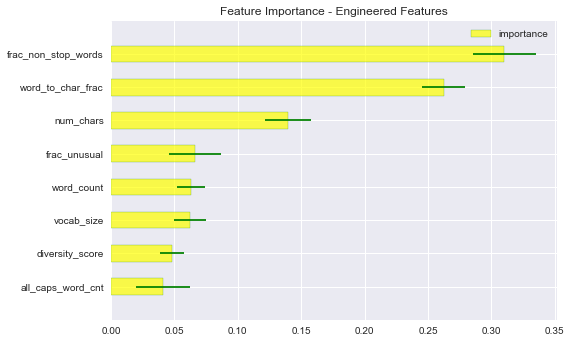

In [102]:
cmap = cm.get_cmap('Spectral')

feature_importance_df.plot(kind='barh',
                           xerr='std', 
                           color='yellow', alpha=0.70,
                           ecolor='green', edgecolor='green')
plt.yticks(range(feature_importance_df.shape[0]), 
           [feature_importance_df['feature'][i] for i in feature_importance_df.index])
plt.ylim([-1, feature_importance_df.shape[0]])
plt.title('Feature Importance - Engineered Features')
save_fig("feature_importance_hand_crafted_features",tight_layout=False)
plt.show()

## Applying a [Voting Classifier](http://scikit-learn.org/stable/modules/generated/sklearn.ensemble.VotingClassifier.html#sklearn.ensemble.VotingClassifier)
-----
* a quick attempt at combining the three models to vote on the predictions
* applying a soft voting based on the argmax of the sums of predicted probabilities
* applying hard/majority rule classifier for unifying estimators

## Test Sentences from, urbandictionary.com
-----
The idea is to grab and label polarized sentences from yet another source. This will help demonstrate if the model is generalizing well, investigate any shortcomings/look for inspiration for ideas of improvement.

In summary, these work pretty well. The ones that were missed, would be challenging even as a human, without more context like speaker's disposition/bias, or word intention/meanings. 

Also, using a strategy of the two highest probabilites per class would do quite nicely. An example is Index 2 "Nah, that place is a total touristaurant, my food was awful last time I ate there." where Bag-of-Words choked but the other two models were within the top quartile of predicting negative sentiment.

In [ ]:
# document & score
contrived_sents = [("Expensive restaurants with horrible food that people still go to for the prime location or atmosphere.", 0), 
 ("It has a beautiful view of the Eiffel Tower!", 1),
 ("Nah, that place is a total touristaurant, my food was awful last time I ate there.", 0),
 ("I had a great day, climbed a hill and didn't check facebook.", 1),
 ("That corgi-shaped macaron is expensive because it's got instagram tax.", 1),
 ("That 1962 Alfa Romeo is good for transportainment", 1),
 ("not so great for getting to work in the snow", 0),
 ("This is so sad Alexa play despacito", 0),
 ("This better not escalate to Dutch ovens any time soon...", 0),
 ("Oh. It has too many calories for me. Well, OK.", 1),
 ("Mmm, this pizza is some good food.", 1),
 ("Food's better for throwing at someone than eating.", 0), 
 ("Are you finished with your restau-rant? I get it, we're outta here. Let's pay the check and leave.", 0),
 ("The Primrose Bar and Restaurant in Ballynahinch, Co. Down in the north of Ireland is one of the best in the country. ",  1),
 ("This burger is crappy.", 0),
 ("DUDE! I got buffungled by Amazon.com with a 8-12 day shipping time!", 0),
 ("I am going to <b>BUY</b> that game RIGHT NOW.", 1),
 ("wow, that was great!", 1),
 ("That movie was great!", 1),
 ("The computer crashed again. I lost three thousand lines of code.", 0)
]

df_contrived = pd.DataFrame(contrived_sents,columns=['document','score'])
df_contrived.head()

In [ ]:
# predict on the three models and review

# load saved CountVecorizer and LogisticRegression models
vect = joblib.load('./models/bows_default_2018-08-08.pkl')
lr_clf = joblib.load('./models/logistic_regression_w_bows_2018-08-08.pkl')

# transform and predict
x_bows = vect.transform(df_contrived['document'].as_matrix())
y_pred_proba_bows = lr_clf.predict_proba(x_bows)

df_contrived['bows_0'] = y_pred_proba_bows[:,0]
df_contrived['bows_1'] = y_pred_proba_bows[:,1]

In [ ]:
# load TfidfVectorizer and LogisticRegression models

tfidf_vect = joblib.load('./models/tfidf_default_2018-08-08.pkl')
lr_clf_2 = joblib.load('./models/logistic_regression_w_tfidf_2018-08-08.pkl')

# transform and predict
x_tfidf = tfidf_vect.transform(df_contrived['document'].as_matrix())
y_pred_proba_x_tfidf = lr_clf_2.predict_proba(x_tfidf)

df_contrived['tfidf_0'] = y_pred_proba_x_tfidf[:,0]
df_contrived['tfidf_1'] = y_pred_proba_x_tfidf[:,1]

In [ ]:
# word2vec and Logistic Regression

# clean the data
df_contrived['tokens'] = df_contrived["document"].apply(h.replace_contractions) \
                                               .apply(nltk.word_tokenize) \
                                               .apply(h.normalize) \
                                               .apply(h.lemmatize_verbs)
display(df_contrived[['document','tokens']].head())

# create the embeddings using gensim
word2vec_embeddings = get_word2vec_embeddings(word2vec,
                                              all_reviews=df_contrived)

# predict the test set with the trained word2vec + Logistic Regression model
#y_pred_w2v = lr_clf_w2v.predict(word2vec_embeddings)
y_pred_proba_w2v = lr_clf_w2v.predict_proba(word2vec_embeddings)

df_contrived['w2v_0'] = y_pred_proba_w2v[:,0]
df_contrived['w2v_1'] = y_pred_proba_w2v[:,1]

In [ ]:
df_contrived[['document','score','bows_1','tfidf_1','w2v_1']]

In [ ]:
# explore topics on the urbandictionary.com sentences
from gensim import corpora
dictionary = corpora.Dictionary(df_contrived['tokens'])
doc_term_matrix = [dictionary.doc2bow(doc) for doc in all_reviews['tokens']]
lda = gensim.models.ldamodel.LdaModel
ldamodel = lda(doc_term_matrix, num_topics=2, id2word = dictionary, passes=50)
print(ldamodel.print_topics())

## Conclusion
-----
Sentiment analysis is challenging in practice, due to many of the constraints of models. Often times, the size of the text being classified is a factor. The longer the text, the less accurate the classification simply because there is a greater chance of ambiguity. Additionally, tuning a model to a particular data source may provide better metrics at the likely cost of sacrificing the generalizable model. And, as is true with most text-based tasks, the more data the better the model can be, which is dependent upon human or perhaps a semi-supervised method to get enough labels for modelling. 

In this capstone, we aimed at creating a generalizable model. Hence, the data chosen was aggregated from three separate sources: reviews from Yelp, Amazon, and iMDB. The idea being that in order to create a more generalizable model, the more diverse the data the better. The data is diverse from a site perspective, a product/industry perspective, and a language usage perspective (proper prose all the way to the gutter). The driver for chosing the models in this CapStone was immediate ease of interpretability, which is necessary in my industry for business/model validation committes et al buy-in/adoption.

The experiment was begun by calculating a naive predictor as the baseline. Then, a default model baseline was established with minimal preprocessing and a simple frequency count to bag of words utilized by a linear regression model for classification (sklearn.CountVectorizer + sklearn.LogisticRegression). This baseline was then compared to a similar approach but switching out a a simple count frequency data representation for sklearn.TfidfVectorizer. Both results were very similar. However, one interesting observation was that even though the two models' metrics were similar, the actual instances where mistakes were made had sufficient non-overlap that a strategy could be devised to achieve higher metrics than just using either model individually.

Next, hand-crafted feature engineering was tried by thinking about constructing features on information that might be lost due to preprocessing (removing punctuation, lower casing words, unusual and misspelled words, the richness of text, the fractions of stop words, etc.). Even with the use of grid search among six different models, the results were below the baseline of linear regression on a simple bag of words. This was extremely dissappointing as it involved a large time commitment. However it also goes to demonstrate the power of this simple model.

Finally, a distributed vector was tried using a word2vec model created by Google researchers. The main advantages here is its ability to utilize words which have not been seen in the training data, as well as allowing for comparing similarities via vectors, either on the word-level or the document level. To incorporate the word2vec model, an average vector was created per document, which was then fed to Logistic Regression for prediction. This model was a noted improvement above the simple Bag of Words baseline. But, when an attempt was made to improve upon the word2vec + Logistic Regression model, via grid search, there wasn't much to be gained, so it would be better to use the first version.

With the three strongest models being so close in terms of metrics, I collected some contrived sentences from UrbanDictionary.com and labelled them myself. Then, I predicted sentiment with the three models for comparison. This sort of technique seems feasable to explore weakness in the model. Using a strategy of the two highest probabilites per class did quite nicely, in this small sample.

With all of this in mind, there are many interesting routes to pursue for increased performance. First steps might be testing a voting strategy between the three successful models, gathering more data for training, and trying different representations of data like part-of-speech and named entity recognition. Casting a wider net on models utilized, perhaps even state-of-the-art, is published enough to make it worthwhile to experiment. So, naturally LSTMs and CNNs come to mind as next steps. And, with exciting and recently published techniques like LIME (local Interpretable Model-Agnostic Explanations) the door may have swung a little wider to acceptable models in the business' eyes.

### References Aides
-----
* [should I normalize/standardize/rescale the data](http://www.faqs.org/faqs/ai-faq/neural-nets/part2/section-16.html)
* [sklearn LogisticRegression docs](http://scikit-learn.org/stable/modules/generated/sklearn.linear_model.LogisticRegression.html#sklearn.linear_model.LogisticRegression.predict_log_proba)
* [About Logistic Regressions from stats.stackexchange](https://stats.stackexchange.com/questions/24405/analyzing-logistic-regression-coefficients)
* [Plot class probabilities calculated by the VotingClassifier](http://scikit-learn.org/stable/auto_examples/ensemble/plot_voting_probas.html#sphx-glr-auto-examples-ensemble-plot-voting-probas-py)
* [python-graph-gallery](https://python-graph-gallery.com/33-control-colors-of-boxplot-seaborn/)
* [vector space model](https://en.wikipedia.org/wiki/Vector_space_model) - applications in relevance rankings, most common being cosine similarity and tf-idf (which is good for short docs but not long ones - b/c similarity becomes less w/ length)
* [latent semantic analysis](https://en.wikipedia.org/wiki/Latent_semantic_analysis#Latent_semantic_indexing)

* Gensim word2vec
  * **[Gensim](https://radimrehurek.com/gensim/)** – Topic Modelling for Humans
  * [Google's paper](https://code.google.com/archive/p/word2vec/), code for word2vec, and published pre-trained word2vec model (~1.6 GB file size)
  * [Google Open Source Blog - Learning the meaning behind words, 2013](https://opensource.googleblog.com/2013/08/learning-meaning-behind-words.html)
  * [Learning Representations of Text using Neural Networks, Tomas Mikolov, 2013](https://docs.google.com/file/d/0B7XkCwpI5KDYRWRnd1RzWXQ2TWc/edit)
  * [gensim word2vec embeddings - for missing words](https://radimrehurek.com/gensim/models/word2vec.html)
  * [gensim word2vec tutorial](https://rare-technologies.com/word2vec-tutorial/#app)
  * [machine learning mastery word2vec and GloVe](https://machinelearningmastery.com/develop-word-embeddings-python-gensim/)

* arXiv papers
  * [Enriching Word Vectors with Subword Information, Piotr Bojanowski](https://arxiv.org/abs/1607.04606)
  * [The Evolution of Sentiment Analysis - A Review of Research Topics, Venues, and Top Cited Papers](https://arxiv.org/ftp/arxiv/papers/1612/1612.01556.pdf)
  * [Assessing State-of-the-Art Sentiment Models on State-of-the-Art Sentiment Datasets](http://www.aclweb.org/anthology/W17-5202)
  * [Distributed Representations of Words and Phrases and their Compositionality, Tomas Mikolov, 2013](https://arxiv.org/pdf/1310.4546.pdf)
  * [Efficient Estimation of Word Representations in Vector Space, Thomas Mikolov, 2013](https://arxiv.org/pdf/1301.3781.pdf)

### Reference Notes
-------

  * **Noise Reduction** - removing non-relevant text to the context of the data (stop words, URLs/links, social media entities, punctuations and industry specific words, etc.)
  * **Lexicon Normalization** - feature engineering step by converting versions of a word into a lemma, effectively reducing dimensionality
    * stemming - rule-based, removing suffixes
    * lemmatization - obtaining root form of word, using a vocabulary (standard lexical dictionary for importance of words) and morphological analysis (word structure and grammar relations)
  * **Object Standardization** - often using regex to handle non-standard speech like acronyms, hashtags, and slang by creating a dictionary and a lookup method to map and replace such objects.
  * **Syntactic Parsing** - 
    * **Dependency Grammar** - dependency trees finding root word of sentence with subtrees, making use of tripplets (relation, governor, dependent)
    * **Part of Speech (POS) tags** - nouns, adjectives, adverbs, ett. but in finer detail like in this [Penn Treebank project list](https://www.ling.upenn.edu/courses/Fall_2003/ling001/penn_treebank_pos.html)
      * reduces word ambiguities, when can have several meanings
      * feature engineering, improving word-based features enabling models to learn proper context w/ the tag
      * normalization and lemmatization based on POS tags
      * efficient stopword removal by tagging low fequency words
  * **Entity Extraction** - 
    * **Named Entity Recognition (NER)** consists of blocks
      * noun phrase id - uses dependency parcing and pos tagging
      * phrase classification - noun phrases to categories
      * entity disambiguation - a validation layer to correct misclassified entities, typically using knowledge graphs like [Google Knowledge Graph](https://www.google.com/intl/en_us/insidesearch/features/search/knowledge.html) or IBM Watson and Wikipedia
    * **Topic Modeling** - id topics present in a corpus
      * Latent Dirichlet Allocation [(LDA)](http://scikit-learn.org/stable/modules/generated/sklearn.decomposition.LatentDirichletAllocation.html) is popular
      * [On Finding the Natural Number of Topics with Latent Dirichlet Allocation: Some Observations, R. ArunV. SureshC. E. Veni MadhavanM. N. Narasimha Murthy](https://link.springer.com/chapter/10.1007%2F978-3-642-13657-3_43)
  
  * **Text Summarization** - taking large text data and reducing to most important and relevant topics/sentences
  
  * **Machine Translation** - translating between human languages, using grammar, semantics and real world info
  
  * **Natural Language Generation and Understanding** - converting information from text data or semantic intents into human-readable text. This can include constructing more logical structures, as a preprocessing step for models
  
  * **Optical Character Recognition** -convert visual images of text to text data
  
  * **Document to Information** - preprocessing like parsing text data from sources to standard formats for analyzing/modeling


